# Locally Linear Embedding

## Unsupervised Learning Final Exam 
### Tanja Derin

Locally Linear Embedding (LLE) is a nonlinear dimensionality reduction technique, designed specifically for data that lies on a curved surface. LLE preserves local relationships between data points. 

By leveraging the local symmetries of linear reconstructions, LLE can uncover the global structure of the manifold without explicitly defining a distance metric in the embedded space.

LLE operates under the key assumption that each data point and its neighbors lie on or near a locally linear patch of the manifold.

## Import tools

In [ ]:
import numpy as np
from numpy.linalg import solve
from scipy.linalg import eigh  # Use eigh, which is optimized for symmetric matrices
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from sklearn.datasets import load_iris
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import kagglehub
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from sklearn.utils.validation import check_array
from scipy.spatial.distance import cdist
import sklearn

## Overview of Locally Linear Embedding

Locally Linear Embedding is a three-step algorithm that reduces the dimensionality of data while preserving the local structure of the manifold. By preserving local linear relationships, LLE reconstructs the data in a lower-dimensional space that captures the intrinsic structure of the manifold.

The three main steps of LLE are:

1. **Find the k-Nearest Neighbors**:
   - For each data point $x_i$, find its $k$-nearest neighbors in the original high-dimensional space.
   - This step identifies the local geometry of the data.

2. **Compute Reconstruction Weights**:
   - Represent each data point $x_i$ as a linear combination of its $k$-nearest neighbors using weights $w_{i,j}$.
   - These weights minimize the reconstruction error while ensuring local linearity.

3. **Compute the Low-Dimensional Embedding**:
   - Map each data point $x_i$ to a low-dimensional point $y_i$ in such a way that the reconstruction weights $w_{i,j}$ are preserved in the lower-dimensional space.

The figure below illustrates the steps of the LLE algorithm:

![LLE Steps](lle.png)

In the following sections, we will explore each step in detail and implement them.


## Step 1: Defining Neighborhoods

The first and most critical step is to define the neighborhood for each data point. This step is crucial because LLE reconstructs each data point as a linear combination of its neighbors, preserving the local geometries in the lower-dimensional embedding. The quality of the neighborhood definition directly impacts the effectiveness of the dimensionality reduction process.

#### Neighborhood Matrix $X_i$
The neighborhood matrix $X_i$ for a data point $x_i$ contains the coordinates of its $k$ nearest neighbors in the high-dimensional space. Each column in $X_i$ represents one of the $k$ nearest neighbors of $x_i$, capturing the local structure around the data point.

The choice of how to define neighborhoods is guided by the dataset's characteristics. Two common approaches are:


- ##### K-Nearest Neighbors (k-NN) Method 
  Identifies the $k$ closest data points to $x_i$ based on a chosen distance metric, typically **Euclidean distance**. Here, $k$ is specifying the number of neighbors.:
  $$
  \|x_i - x_{ij}\| < \|x_i - x_{il}\|, \quad \forall l \notin \{1, 2, \ldots, k\}
  $$
  where $x_{ij}$ are the $k$ nearest neighbors of $x_i$.

- ##### Epsilon-Neighborhood ($\epsilon$-Neighborhood) Method
  Defines the neighborhood as all points within a fixed radius $\epsilon$ from each data point $x_i$. This method adapts to variations in point density, allowing the neighborhood size to change depending on the local structure of the data.
  $$
  \|x_i - x_j\| < \epsilon, \quad \forall j
  $$
  where $\epsilon$ is a predefined distance threshold.


The choice between the **k-NN method** and the **epsilon-neighborhood method** depends on the dataset's distribution and the desired balance between locality and flexibility. 

- **k-NN**: Better for datasets with uniform density, as the number of neighbors is fixed for each point.
- **Epsilon-Neighborhood**: More suitable for datasets with varying density, as the size of the neighborhood adapts dynamically.

To compute the neighborhoods for each data point, the following functions are used:
- **`find_k_neighbors`** identifies the `n_neighbors` closest points for each data point based on Euclidean distance
- **`find_epsilon_neighbors`** finds all neighbors within a fixed radius `epsilon` for each data point, returning a list of arrays with neighbor indices.
- **`get_neighbors`** serves as a general interface, allowing users to choose between the `k-nearest neighbors` or `epsilon-neighborhood` approach based on the specified parameter. 

In [284]:
def find_k_neighbors(X, n_neighbors):
    """Find k-nearest neighbors for each point in X, ensuring all points have exactly n_neighbors."""
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    # Ensure every point has exactly n_neighbors, potentially by repeating neighbors
    for i in range(len(indices)):
        if len(indices[i]) < n_neighbors:
            required = n_neighbors - len(indices[i])
            repeated_indices = np.random.choice(indices[i], size=required)
            indices[i] = np.concatenate([indices[i], repeated_indices])
        assert len(indices[i]) == n_neighbors, f"Indices for point {i} do not match n_neighbors"

    return indices

def find_epsilon_neighbors(X, epsilon, min_neighbors=None):
    """
    Find all neighbors within epsilon distance for each point in X. 
    Ensures all points meet a minimum number of neighbors if specified.
    """
    nn = NearestNeighbors(radius=epsilon)
    nn.fit(X)
    indices = nn.radius_neighbors(X, return_distance=False)

    # Enforce minimum neighbors if specified
    if min_neighbors is not None:
        for i in range(len(indices)):
            if len(indices[i]) < min_neighbors:
                # Fallback to k-NN for this point
                nn_knn = NearestNeighbors(n_neighbors=min_neighbors)
                nn_knn.fit(X)
                _, knn_indices = nn_knn.kneighbors(X[i].reshape(1, -1))
                indices[i] = knn_indices[0]
    
    return indices

def get_neighbors(X, n_neighbors=None, epsilon=None, min_neighbors=None):
    """
    General function to get neighbors either by k-nearest or epsilon method.
    Ensures consistency in neighborhood size with a fallback mechanism.
    """
    if n_neighbors is not None:
        return find_k_neighbors(X, n_neighbors)
    elif epsilon is not None:
        return find_epsilon_neighbors(X, epsilon, min_neighbors)
    else:
        raise ValueError("Either n_neighbors or epsilon must be specified.")

After defining the neighborhoods using either the k-nearest neighbors or the epsilon-neighborhood method, the next step is constructing the neighborhood matrix for each data point. It will be later used in LLE for:

- **Weight Calculation**: The neighborhood matrix $X_i$ plays a crucial role in the weight computation step. The goal is to find the weights $w_{i,j}$ that best reconstruct $x_i$ as a linear combination of its neighbors. This is achieved by minimizing the reconstruction error, which quantifies how well the neighbors approximate $x_i$.

- **Embedding Process**: Once the weight matrix is computed, it is used to embed the high-dimensional data into a lower-dimensional space. The embedding preserves the local neighborhood relationships by maintaining the same reconstruction weights in the lower-dimensional representation.

In [ ]:
def get_X_neighbors(X, indices):
    """Constructs the neighborhood matrix $X_i$ for each data point based on the provided neighbor indices."""
    n_samples = len(indices)
    n_neighbors = len(indices[0])  # Assumes each list of indices has the same length
    n_features = X.shape[1]

    # Initialize the array to hold neighbor data
    X_neighbors = np.empty((n_samples, n_neighbors, n_features), dtype=X.dtype)
    
    # Populate the neighbor data
    for i in range(n_samples):
        assert len(indices[i]) == n_neighbors, "Inconsistent number of neighbors"
        X_neighbors[i] = X[indices[i]]
    
    return X_neighbors

Before proceeding to the weight computationđ, we validate the neighborhood detection process using a simple example. Here, we generate a **Swiss roll dataset** and identify the neighbors of each data point using the k-nearest neighbors method and visualize these neighborhoods in the 3D space.

In the following code:
- Generate the Swiss roll dataset with 1000 samples.
- Use the `get_neighbors` function to identify the 5 nearest neighbors for each point.
- Retrieve the positions of these neighbors with `get_X_neighbors`.
- Visualize the dataset in 3D and plot lines connecting each point to its neighbors, illustrating the neighborhood structure.

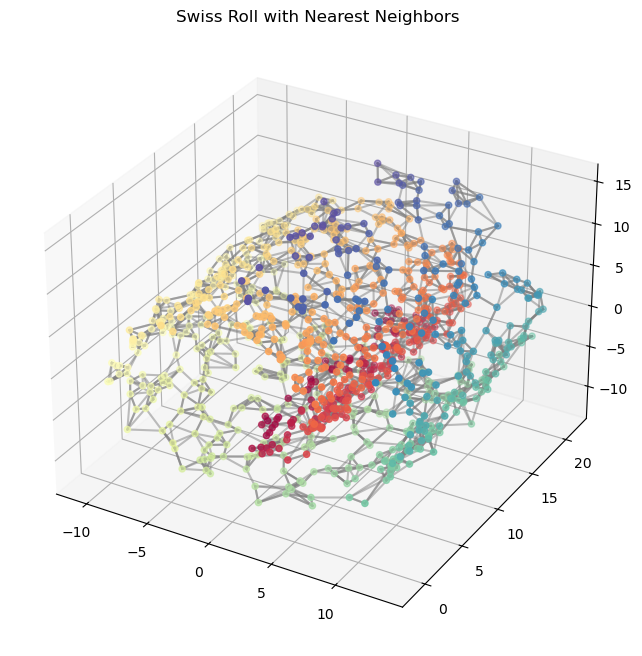

In [ ]:
# Generate the Swiss roll data
X, colors = make_swiss_roll(n_samples=1000, noise=0.5)

# Define the number of neighbors
n_neighbors = 5

# Find neighbors
indices = get_neighbors(X, n_neighbors=n_neighbors)

# Get the neighbor's positions
X_neighbors = get_X_neighbors(X, indices)

# Plotting to visualize the points and their neighbors
plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap=plt.cm.Spectral)

# Draw lines between each point and its neighbors
for i in range(len(X)):
    for j in indices[i]:
        if i != j:  # Avoid self-connection
            ax.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], [X[i, 2], X[j, 2]], 'gray', alpha=0.5)

plt.title('Swiss Roll with Nearest Neighbors')
plt.show()

## Step 2: Find the weights

This section describes the mathematical formulation to compute the reconstruction weights and the method to solve for these weights using the Lagrange multiplier technique.

The weights are crucial as they are used to preserve the geometric configurations of the data points when mapped to a lower-dimensional space.

### Defining the Problem
For a given data point $x_i \in \mathbb{R}^d$, the objective is to express $x_i$ as a linear combination of its $k$ nearest neighbors. This is mathematically represented as:

$$ x_i \approx \sum_{j=1}^{k} w_{ij} x_{ij} $$

where:
- $x_{ij}$ denotes the $j$-th nearest neighbor of $x_i$.
- $w_{ij}$ is the weight corresponding to the $j$-th neighbor, indicating its contribution to the reconstruction of $x_i$.


### Objective Function
The goal is to minimize the reconstruction error, defined as the squared Euclidean distance between $x_i$ and its reconstruction from the neighbors:

$$ \epsilon(W) = \sum_{i=1}^{n}\|x_i - X_i w_i\|^2 $$

where $w_i$ is the vector of weights $[w_{i1}, w_{i2}, \ldots, w_{ik}]^T$ for the neighbors of $x_i$.

**Constraint**:
    - The weights for each data point must sum to one to ensure a valid convex combination:

$$ \sum_{j=1}^k w_{ij} = 1 $$


### Gram Matrix Computation
To simplify the computation of the reconstruction error, we expand the error term as follows:

$$
\epsilon(W) = \|x_i - X_i \tilde{w_i}\|^2
$$

The constraint $ \sum_{j=1}^k \tilde{w_{i,j}} = 1$ implies that $\mathbf{1}^T \tilde{w_i} = 1$ therefore, $x_i = X_i \mathbf{1} \tilde{w_i}.$ We can substitute $ x_i$:

$$
\epsilon(W) = \| x_i \mathbf{1} \tilde{w_i} -  X_i \tilde{w_i}\|^2 = \|(x_i \mathbf{1}^T - X_i)  \tilde{w_i}\|^2
$$
$$
\epsilon(W) = \tilde{w}_i^T \big((x_i \mathbf{1}^T - X_i)^T (x_i \mathbf{1}^T - X_i)\big) \tilde{w}_i
$$

Define the **Gram matrix** $G_i$ as:

$$
G_i = (x_i \mathbf{1}^T - X_i)^T (x_i \mathbf{1}^T - X_i)
$$

The reconstruction error becomes:

$$
\epsilon(W) = \tilde{w}_i^T G_i \tilde{w}_i
$$

Here:
- $G_i$ is the Gram matrix, capturing the local geometry of the data around $x_i$.
- $ G_i$ represents the inner product of the difference vectors $(x_{ij} - x_i)$.


The weights are found by minimizing the reconstruction error subject to the weights summing to one:

$$ \text{minimize } \sum_{i=1}^n w_i^T G_i w_i $$
$$ \text{subject to } \mathbf{1}^T w_i = 1 $$

This is solved using a Lagrange multiplier to incorporate the constraint, leading to a solution for $w_i$ that can be computed directly or through iterative numerical methods. Introduce a Lagrange multiplier $\lambda$ for the constraint and form the Lagrangian:

$$ \mathcal{L} = \sum_{i=1}^n w_i^T G_i w_i - \sum_{i=1}^n \lambda_i (\mathbf{1}^T w_i - 1) $$

Setting the derivative of the Lagrangian with respect to $w_i$ and $\lambda_i$ to zero, we get:

$$ \frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda_i \mathbf{1} = 0 $$
$$ \frac{\partial \mathcal{L}}{\partial \lambda_i} = \mathbf{1}^T w_i - 1 = 0 $$

From the above, we derive:

$$ w_i = \frac{1}{2} G_i^{-1} \lambda_i \mathbf{1} $$
$$ \lambda_i = \frac{2}{\mathbf{1}^T G_i^{-1} \mathbf{1}} $$

Thus:

$$ w_i = \frac{G_i^{-1} \mathbf{1}}{\mathbf{1}^T G_i^{-1} \mathbf{1}} $$

This equation shows that the weights $w_i$ can be computed directly using the inverse of $G_i$, scaled by the sum of the inverted values, ensuring that the sum of the weights equals one.

### Regularization and Implementation Notes
The matrix $G_i$ is regularized to prevent singularities, especially when $k > d$ (number of neighbors exceeds the number of dimensions):

$$ G_i \rightarrow G_i + \lambda I $$

where $\lambda$ is a small regularization term and $I$ is the identity matrix. 


To avoid the explicit inversion of $G_i$, the weights are usually solved more efficiently using numerical methods for solving linear systems, as direct matrix inversion can be computationally expensive and numerically unstable.


In [ ]:
def weights(X, Z, neighbors_idx, reg=1e-3):
    """
    Compute weights of X from Z along the first axis.

    Parameters:
    X : numpy.ndarray
        High-dimensional data points, shape (n_samples, n_dim).
    Z : numpy.ndarray
        Neighbors of each sample in X, shape (n_samples, n_neighbors, n_dim).
    neighbors_idx : list of arrays
        Indices of the neighbors for each data point.
    reg : float, optional
        Amount of regularization to add for the problem to be well-posed.

    Returns:
    numpy.ndarray
        Barycenter weights for each neighbor, shape (n_samples, n_neighbors).
    """
    n_samples = X.shape[0]
    W = np.zeros((n_samples, n_samples))  # Ensure W is n_samples x n_samples
    for i in range(n_samples):
        n_neighbors = Z[i].shape[0]  # Get the number of neighbors for the current point
        A = Z[i].T  # Transpose to shape (n_dim, n_neighbors)
        X_i = X[i].reshape(-1, 1)  # Reshape for broadcasting
        C = A - X_i  # Compute differences
        G = np.dot(C.T, C)  # Gram matrix
        trace = np.trace(G)
        R = reg * max(trace, 1e-10)  # Regularization to avoid ill-conditioned G
        G += np.eye(n_neighbors) * R  # Add regularization
        v = np.ones(n_neighbors)
        w = solve(G, v)  # Solve Gw = v
        w /= np.sum(w)  # Normalize weights
        W[i, neighbors_idx[i]] = w  # Set the weights in the matrix

    return W

##### Visualizing the Weights

Before proceeding to the embedding step we visualize the weights computed for reconstructing a data point from its neighbors. This helps in understanding how each neighbor contributes to the linear reconstruction of the original data point.

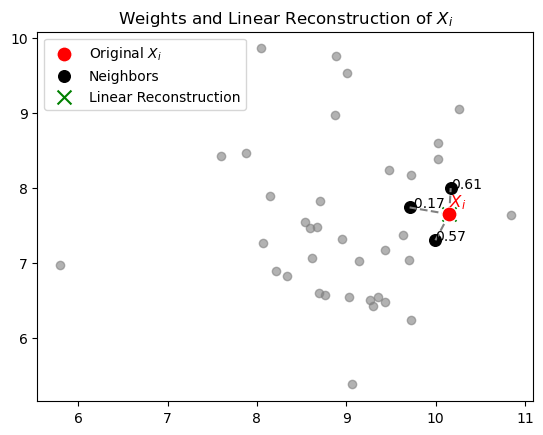

In [290]:
# Create a synthetic dataset
X, _ = make_blobs(n_samples=40, centers=1, n_features=2)

# Define the number of neighbors
n_neighbors = 3

# Find neighbors using KNN
nn = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
distances, indices = nn.kneighbors(X)

# Exclude the point itself from its list of neighbors
indices = indices[:, 1:]

# Get the neighbor coordinates
X_neighbors = np.array([X[indices[i]] for i in range(X.shape[0])])

# Call your weights function
weights_matrix = weights(X, X_neighbors, indices)

# Select a point to visualize
ix = 5  # Example index of the point to visualize
xi_neighbors = indices[ix]
xi_weights = weights_matrix[ix, xi_neighbors]

# Compute the linear reconstruction
linear_X = np.dot(xi_weights, X[xi_neighbors])

# Visualization
plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6)  # all points in gray
plt.scatter(X[ix, 0], X[ix, 1], c='red', edgecolors='white', s=120, alpha=1, label='Original $X_i$', zorder=3)
plt.text(X[ix, 0], X[ix, 1] + 0.1, '$X_i$', fontsize=12, color='red')
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='black', alpha=1, s=70, label='Neighbors')
plt.scatter(linear_X[0], linear_X[1], c='green', marker='x', s=100, label='Linear Reconstruction')  # Using 'x' marker
for i, weight in zip(xi_neighbors, xi_weights):
    plt.text(X[i, 0], X[i, 1], f'{weight:.2f}', fontsize=10)
    plt.plot([X[ix, 0], X[i, 0]], [X[ix, 1], X[i, 1]], 'gray', linestyle='--')

plt.title('Weights and Linear Reconstruction of $X_i$')
plt.legend()
plt.show()


## Step 3: Embedding  

In the final step we map the data points into a lower-dimensional space while preserving local neighborhood relations. This is achieved by solving an optimization problem to find new coordinates in the reduced space that maintain these relationships.

### Objective Function

The goal is to minimize the reconstruction error in the embedded space, defined as:

$$ \Phi(Y) = \sum_{i=1}^n \| y_i - \sum_{j=1}^n w_{ij} y_j \|^2 $$

where:
- $ y_i$ represents the coordinates of the embedded data point corresponding to $ x_i $.
- $ w_{ij}$ are the weights calculated in the high-dimensional space, reflecting the contributions of $ x_j$ to $x_i$.

**Constraints**
To ensure the embedding is well-defined, the following constraints are imposed:

1. **Centering Constraint**:  
   The embedded points must be centered at the origin:  
   $$ \sum_{i=1}^n y_i = 0 $$

2. **Covariance Constraint**:  
   The covariance of the embedded points must be the identity matrix:  
   $$ \frac{1}{n} \sum_{i=1}^n y_i y_i^T = I $$  
   This ensures the new dimensions are uncorrelated and have unit variance.

The objective function can be rewritten in matrix form. First, expanding the summation:

$$ \Phi(Y) = \| Y^T (I - W)^T \|_F^2 $$

Here, $ W $ is the weight matrix, and $ \| \cdot \|_F $ denotes the Frobenius norm of a matrix. Expanding this expression further:

$$ \Phi(Y) = \text{tr}\left( (I - W)YY^T (I - W)^T\right)$$

This simplifies to:

$$ \Phi(Y) = \text{tr}(Y^T (I - W)^T (I - W) Y) $$

We define the matrix $M = (I - W)^T (I - W) $, swhere $ (I - W)$ represents the Laplacian matrix of the weight matrix $W$. $M$ is the Gram matrix derived from the Laplacian weight matrix, which ensures that the embedding process preserves the local neighborhood structure captured by $W$. The objective function can then be written as:

$$
\text{minimize}_{Y} \quad \text{tr}(Y^T M Y)
$$

**Subject to**:
 $\frac{1}{n} Y^T Y = I $ and  $Y^T \mathbf{1} = 0$  

By minimizing this trace term, we ensure that the reconstructed relationships in the low-dimensional embedding $𝑌$ are as close as possible to the relationships in the original high-dimensional space while respecting the constraints.

The matrix $ M$ is symmetric, making it suitable for eigen decomposition. To solve for $Y $, the following steps are taken:
1. Compute the eigenvalues and eigenvectors of $M $.
2. The new embedded space is defined by the eigenvectors corresponding to the smallest non-zero eigenvalues of $M$.  
   - **Note**: The smallest eigenvalue is ignored as it corresponds to a trivial solution where all points are identical.

In [47]:
def compute_embedding(W, n_components):
    """
    Computes the embedding of data into a lower-dimensional space using LLE.

    Parameters:
    W : numpy.ndarray
        The weight matrix from LLE, shape (n_samples, n_samples).
    n_components : int
        The number of dimensions to reduce the data to.

    Returns:
    numpy.ndarray
        The embedded data, shape (n_samples, n_components).
    """
    n_samples = W.shape[0]

    # Compute the matrix M = (I - W)^T(I - W)
    I = np.eye(n_samples)  # Identity matrix of shape (n_samples, n_samples)
    M = (I - W).T @ (I - W)  # Matrix for eigen-decomposition

    # Compute the eigenvalues and eigenvectors of the matrix M
    # eigh returns them in ascending order of eigenvalues
    eigenvalues, eigenvectors = eigh(M)

    # Select the n_components smallest eigenvalues and corresponding eigenvectors
    # eigh returns them in ascending order of eigenvalues
    return eigenvectors[:, 1:n_components+1]

## Output

The `my_lle` function encapsulates all three steps of the Locally Linear Embedding algorithm, using k-nearest neighbors (kNN) to define the neighborhood of each point. The function returns the low-dimensional embedding $Y$, which represents the input data in the reduced space.

In [ ]:
def my_lle(X, n_neighbors, n_components):
    neighbors_idx = get_neighbors(X, n_neighbors=n_neighbors)
    X_neighbors = get_X_neighbors(X, neighbors_idx)
    W = weights(X, X_neighbors, neighbors_idx)  # Pass neighbors_idx here
    Y = compute_embedding(W, n_components)
    return Y



The `my_lle_epsilon` function implements Locally Linear Embedding using an epsilon-neighborhood to define neighbors instead of a fixed number of nearest neighbors.

In [285]:
def my_lle_epsilon(X, epsilon, min_neighbors, n_components):
    neighbors_idx = get_neighbors(X, epsilon=epsilon, min_neighbors=min_neighbors)
    X_neighbors = get_X_neighbors(X, neighbors_idx)
    W = weights(X, X_neighbors, neighbors_idx)  # Pass neighbors_idx here
    Y = compute_embedding(W, n_components)
    return Y


# Examples

## Data Visualization

Locally Linear Embedding is useful for visualizing high-dimensional data in two or three dimensions. This technique simplifies the complexity of data with many features, making it possible to identify patterns, clusters, or outliers that are not discernible in higher-dimensional spaces.

### SWISS ROLL

LLE effectively unravels and visualizes complex structures like the Swiss Roll dataset, revealing the underlying 2D manifold structured within a three-dimensional space.

c:\Users\tanja\anaconda3\envs\sci-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


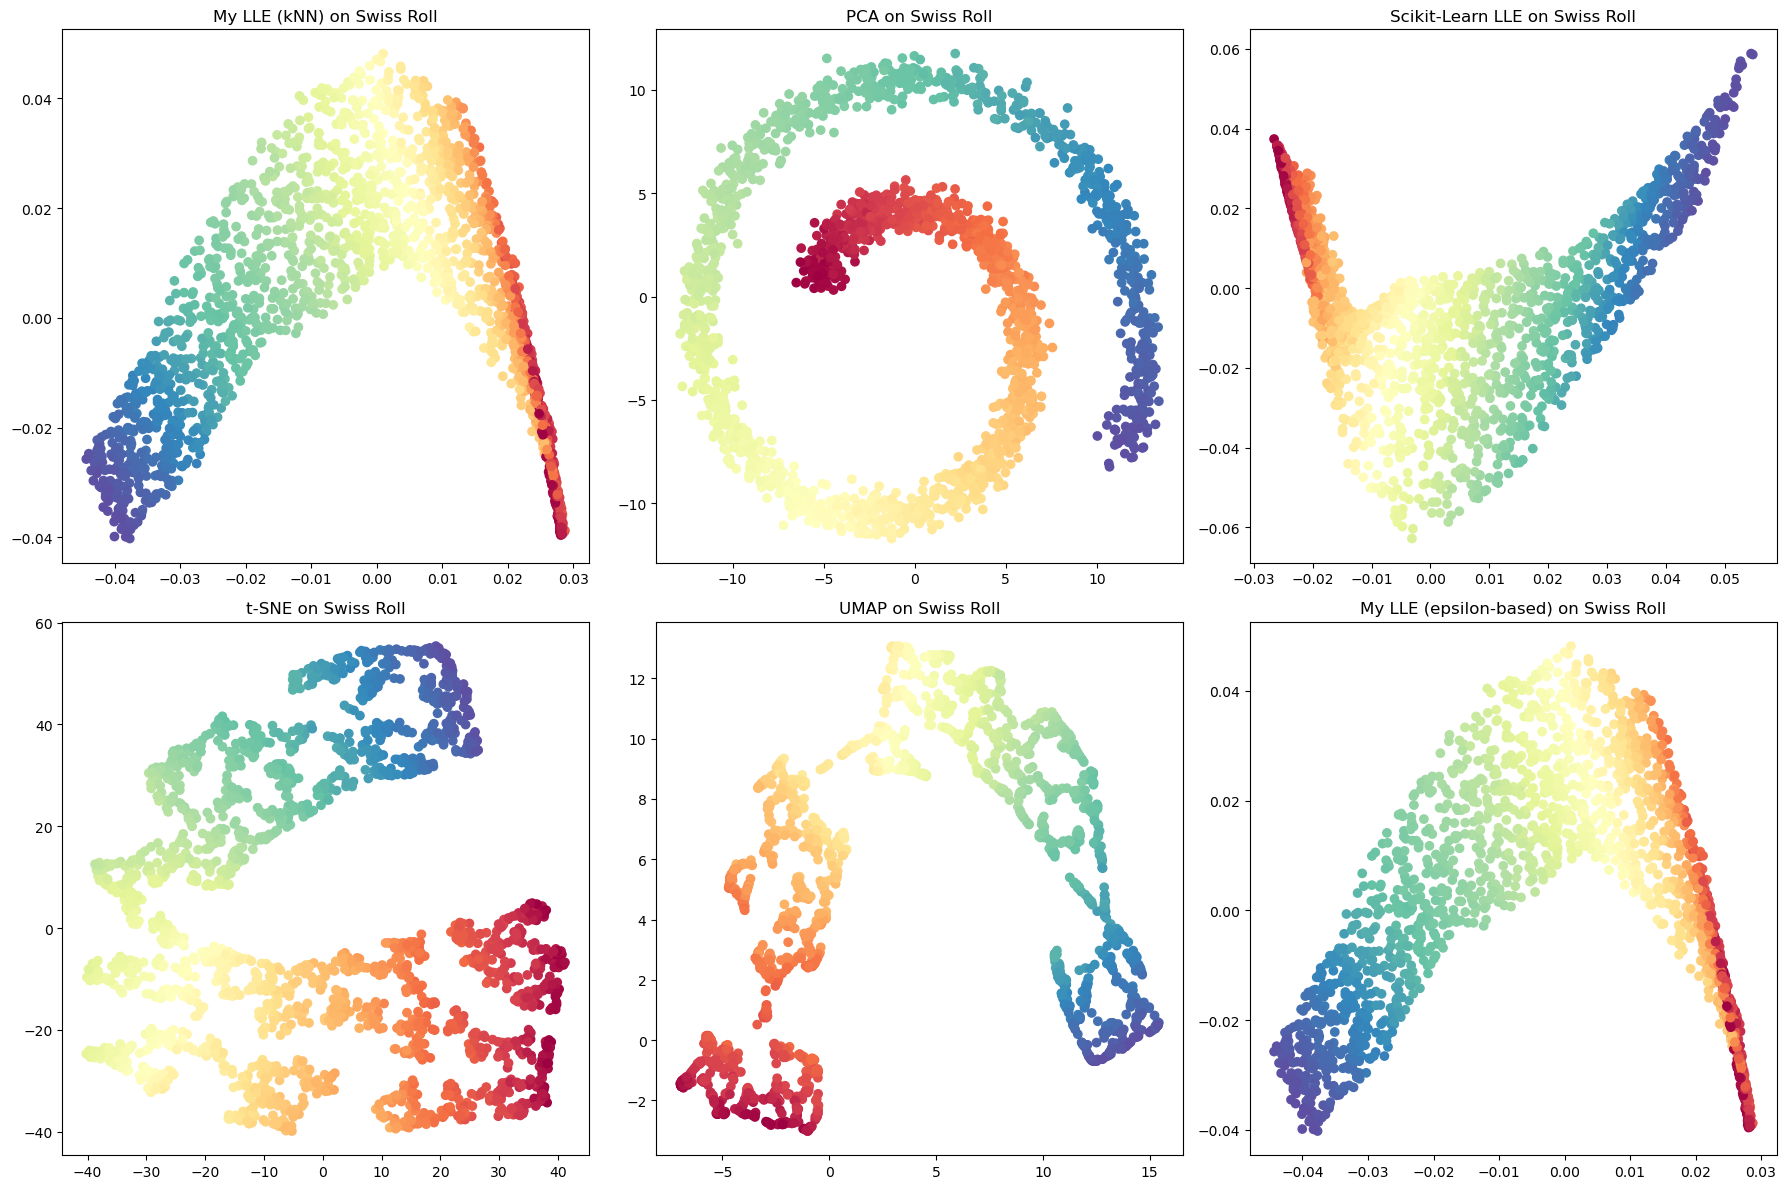

In [289]:
# Generate the Swiss roll data
X, colors = make_swiss_roll(n_samples=2000, noise=0.5)

# Fit the model with your LLE implementation
X_lle = my_lle(X, n_neighbors=10, n_components=2)
# Fit the model with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Fit the model with the library's LLE
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
X_lle_lib = lle.fit_transform(X)
# Fit the model with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)
# Fit the model with UMAP
umap_model = UMAP(n_neighbors=15, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)
# Fit the model with epsilon-based LLE
X_lle_epsilon = my_lle_epsilon(X, epsilon=0.5, min_neighbors=10, n_components=2)


# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# My LLE Plot
ax1 = axes[0, 0]
ax1.scatter(X_lle[:, 0], X_lle[:, 1], c=colors, cmap=plt.cm.Spectral)
ax1.set_title('My LLE (kNN) on Swiss Roll')
# PCA Plot
ax2 = axes[0, 1]
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap=plt.cm.Spectral)
ax2.set_title('PCA on Swiss Roll')
# Library LLE Plot
ax3 = axes[0, 2]
ax3.scatter(X_lle_lib[:, 0], X_lle_lib[:, 1], c=colors, cmap=plt.cm.Spectral)
ax3.set_title('Scikit-Learn LLE on Swiss Roll')
# t-SNE Plot
ax4 = axes[1, 0]
ax4.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, cmap=plt.cm.Spectral)
ax4.set_title('t-SNE on Swiss Roll')
# UMAP Plot
ax5 = axes[1, 1]
ax5.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap=plt.cm.Spectral)
ax5.set_title('UMAP on Swiss Roll')
# My LLE (epsilon-based) Plot
ax6 = axes[1, 2]
ax6.scatter(X_lle_epsilon[:, 0], X_lle_epsilon[:, 1], c=colors, cmap=plt.cm.Spectral)
ax6.set_title('My LLE (epsilon-based) on Swiss Roll')
plt.tight_layout()
plt.show()


The comparison of dimensionality reduction techniques on the Swiss Roll dataset demonstrates several key observations. Both the custom implementations of LLE (using k-NN and epsilon-based neighborhoods) closely align with the official Scikit-Learn LLE implementation, effectively unrolling the manifold while maintaining smoothness and preserving local geometry.

t-SNE and UMAP also successfully unroll the Swiss Roll but exhibit less smooth surfaces, likely due to their focus on preserving local pairwise similarities rather than explicitly maintaining a continuous manifold structure. 

PCA fails to unroll the Swiss Roll entirely, as expected, due to its linear nature, which is not suited for nonlinear manifolds like the Swiss Roll. Overall, LLE appears to excel at maintaining a globally smooth representation, while t-SNE and UMAP may be better suited for visualizing clusters in more complex datasets.



## Parameter 

The LLE algorithm relies on the **Number of Neighbors (\( k \))**. It determines how many neighbors each data point considers for reconstructing itself.

- **Impact**:
  - A smaller \( k \) focuses on very local structures, which can lead to overfitting or disconnected embeddings.
  - A larger \( k \) captures more global structures, but it may blur fine details and lead to higher reconstruction errors.

To explore the impact of varying the number of neighbors on the performance we can plot the 2D embedding obtained from LLE using different neighbor settings neighbors respectively. The plots illustrate how the choice of neighbors affects the unfolding of the Swiss roll.

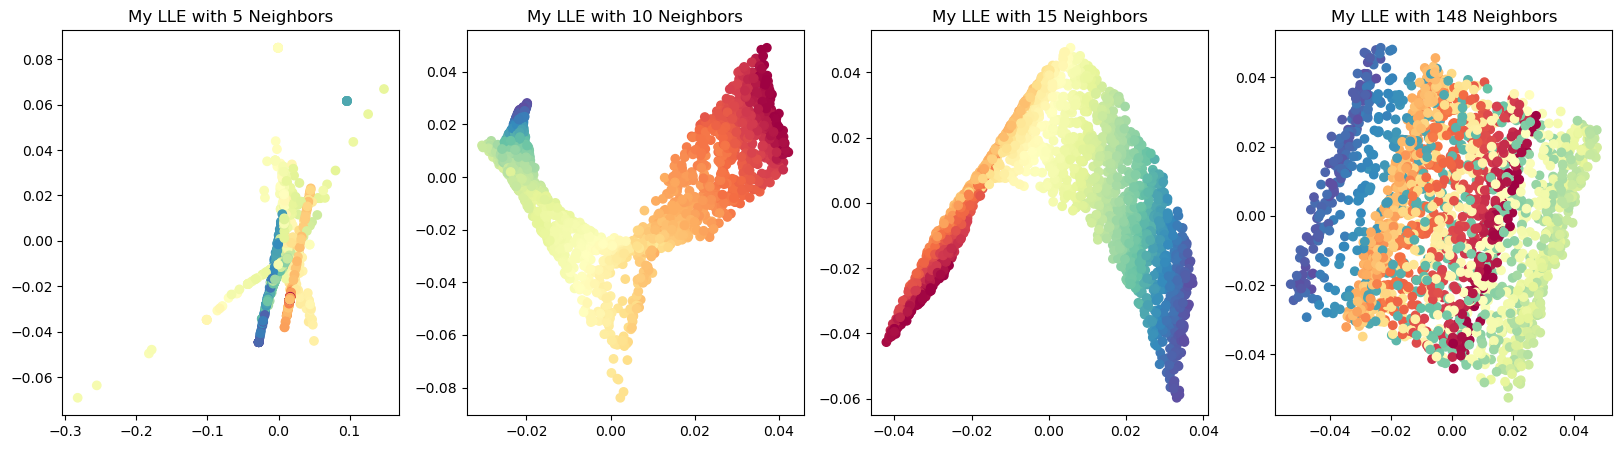

In [50]:
neighbor_settings = [5, 10, 15, 148] # varying the number of neighbors
fig, axes = plt.subplots(1, len(neighbor_settings), figsize=(20, 5))

for i, n_neighbors in enumerate(neighbor_settings):
    # Fit the model with LLE
    X_lle = my_lle(X, n_neighbors=n_neighbors, n_components=2)
    
    # Plot
    ax = axes[i]
    ax.scatter(X_lle[:, 0], X_lle[:, 1], c=colors, cmap=plt.cm.Spectral)
    ax.set_title(f'My LLE with {n_neighbors} Neighbors')

plt.show()

The optimal number of neighbors on the Swiss roll dataset appears to be between 10 and 15. This range shows a balance between sufficient detail and smooth transitions. Lets try to implement an optimal parameter search in the next section.

### Method for Tuning \( k \): Hierarchical Search

This hierarchical approach reduces computational demands by focusing detailed calculations only on promising candidate values rather than exhaustively computing for every possible `k`. The `lle_hierarchical_search` function implements an approach to identify the optimal \( k \) by balancing reconstruction accuracy and residual variance.


##### Steps:
1. **Compute Reconstruction Error**:
   - For each $ k $ in the specified range, calculate the reconstruction error, measures how well each point is reconstructed from its neighbors:
     $$
     \text{Error} = \sum_{i=1}^n \| X_i - \sum_{j=1}^k w_{ij} X_{ij} \|^2
     $$

2. **Find Local Minima**:
   - Identify values of $k$ where the reconstruction error is lower than that for adjacent values, indicating good balance between underfitting and overfitting.

3. **Evaluate Residual Variance**:
   - For each candidate $k$, compute the **residual variance**. A lower residual variance indicates better alignment between the high-dimensional and low-dimensional distance matrices.:
   $$
     \text{Residual Variance} = 1 - \text{correlation}^2
   $$


4. **Select Optimal $k$**:
   - Rank the candidate $k$-values based on residual variance.
   - Return the top three $k$-values and their corresponding residual variances.


In [ ]:
def compute_residual_variance(X, Y):
    """Compute the residual variance as a measure of quality of the embedding."""
    D_high = squareform(pdist(X))
    D_low = squareform(pdist(Y))
    correlation = np.corrcoef(D_high.ravel(), D_low.ravel())[0, 1]
    return 1 - correlation**2

def find_local_minima(errors):
    """Identify local minima in a list of errors to find candidate k values."""
    return [i for i in range(1, len(errors) - 1) if errors[i - 1] > errors[i] < errors[i + 1]]

def compute_reconstruction_error(X, W, neighbors_idx):
    """Calculate the reconstruction error as per the provided LLE formula."""
    n_samples = X.shape[0]
    reconstruction_error = 0
    for i in range(n_samples):
        X_i = X[i]
        neighbors = X[neighbors_idx[i]]
        W_i = W[i, neighbors_idx[i]]
        X_i_reconstructed = np.dot(W_i, neighbors)
        reconstruction_error += np.linalg.norm(X_i - X_i_reconstructed)**2
    return reconstruction_error

def lle_hierarchical_search(X, n_components, k_range):
    """Hierarchical method to find the optimal number of neighbors for LLE."""
    errors = []
    for k in k_range:
        neighbors_idx = get_neighbors(X, n_neighbors=k)
        X_neighbors = get_X_neighbors(X, neighbors_idx)
        W = weights(X, X_neighbors, neighbors_idx)
        error = compute_reconstruction_error(X, W, neighbors_idx)
        errors.append(error)

    candidate_ks = [k_range[i] for i in find_local_minima(errors)]
    
    if candidate_ks:
        residual_variances = {k: compute_residual_variance(X, my_lle(X, n_neighbors=k, n_components=n_components)) for k in candidate_ks}
        sorted_ks = sorted(residual_variances.items(), key=lambda x: x[1])
        top_ks = sorted_ks[:3]  # Get the top three k values
        return [(k, variance) for k, variance in top_ks]  # Corrected to ensure it returns a list of tuples
    else:
        print("No local minima found. Consider adjusting the range or method for finding minima.")
        return None



Parameter tunning on the swiss roll

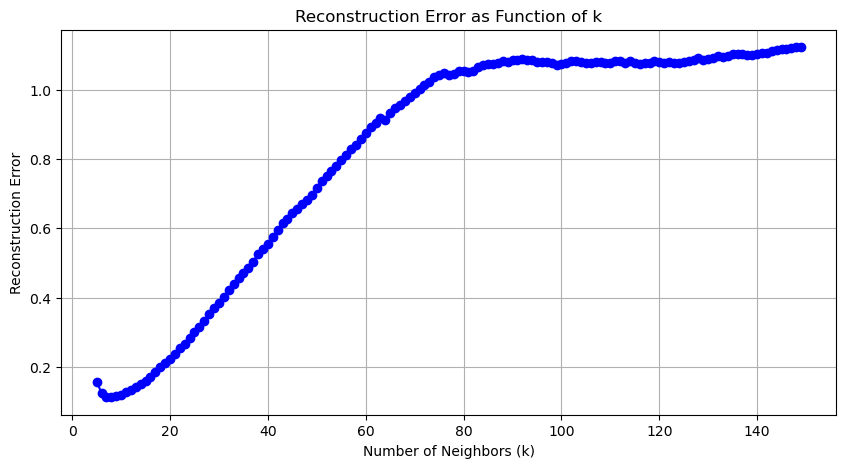

In [57]:
# Define k range and generate data
k_range = range(5, 150)

# Error collection
errors = []
for k in k_range:
    neighbors_idx = get_neighbors(X, n_neighbors=k)
    X_neighbors = get_X_neighbors(X, neighbors_idx)
    W = weights(X, X_neighbors, neighbors_idx)
    error = compute_reconstruction_error(X, W, neighbors_idx)
    errors.append(error)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(list(k_range), errors, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error as Function of k')
plt.grid(True)
plt.show()

In [64]:
top_k_values = lle_hierarchical_search(X, n_components=2, k_range=range(5, 50))
for k, variance in top_k_values:
    print(f"Top k: {k}, Residual Variance: {variance}")

Top k: 8, Residual Variance: 0.8388158665069899


## Fuse LLE with Isomap as ISOLLE

Fusing LLE with Isomap involves using geodesic distances rather than simple Euclidean distances to construct the k-NN graph. This approach could capture the manifold's intrinsic geometry more accurately.

##### Methodology:
1. **Geodesic Distance Calculation**:
   - Instead of using Euclidean distances to define neighbors, geodesic distances are calculated to preserve the global manifold structure. This is inspired by the Isomap algorithm.
   
2. **LLE Embedding**:
   - Once geodesic distances are computed, the standard LLE algorithm is applied to reduce the dimensionality while maintaining the local relationships between points.

In [107]:
def get_geodesic_neighbors(X, n_neighbors):
    """
    Get neighbors using geodesic distances.
    
    Parameters:
    X : numpy.ndarray
        Input data, shape (n_samples, n_features).
    n_neighbors : int
        Number of neighbors for the k-NN graph.
    
    Returns:
    geodesic_neighbors : list of arrays
        Indices of geodesic neighbors for each data point.
    """
    # Create the k-NN graph (sparse adjacency matrix)
    knn_graph = kneighbors_graph(X, n_neighbors, mode='connectivity', include_self=False)
    
    # Compute the shortest paths (geodesic distances)
    geodesic_distances = shortest_path(knn_graph, method='D', directed=False)
    
    # For each point, find the indices of its n_neighbors smallest distances
    geodesic_neighbors = [np.argsort(dist)[:n_neighbors] for dist in geodesic_distances]
    return geodesic_neighbors

In [108]:
def my_isolle(X, n_neighbors, n_components):
    """
    ISOLLE: LLE with geodesic distances.
    
    Parameters:
    X : numpy.ndarray
        Input data, shape (n_samples, n_features).
    n_neighbors : int
        Number of neighbors.
    n_components : int
        Number of dimensions for embedding.
    
    Returns:
    Y : numpy.ndarray
        Embedded data, shape (n_samples, n_components).
    """
    neighbors_idx = get_geodesic_neighbors(X, n_neighbors)  # Use geodesic neighbors
    X_neighbors = get_X_neighbors(X, neighbors_idx)  # Fetch neighbor data
    W = weights(X, X_neighbors, neighbors_idx)  # Calculate weights
    Y = compute_embedding(W, n_components)  # Compute embedding
    return Y


#### Example: Swiss Roll


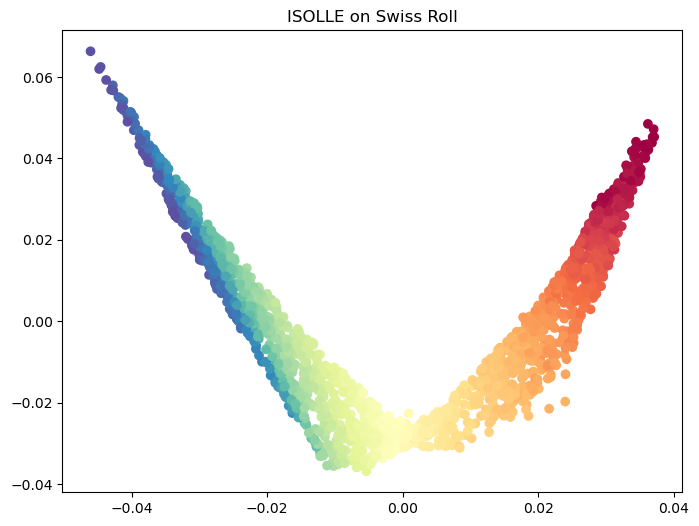

In [ ]:
Y_isolle = my_isolle(X, n_neighbors=10, n_components=2)

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(Y_isolle[:, 0], Y_isolle[:, 1], c=colors, cmap=plt.cm.Spectral)
plt.title("ISOLLE on Swiss Roll")
plt.show()

#### Example: Iris Dataset

The Iris dataset, which consists of 4 features and 3 species, is used to demonstrate how ISOLLE works with different neighbor settings. The goal is to embed the dataset into two dimensions while capturing the relationships between species.

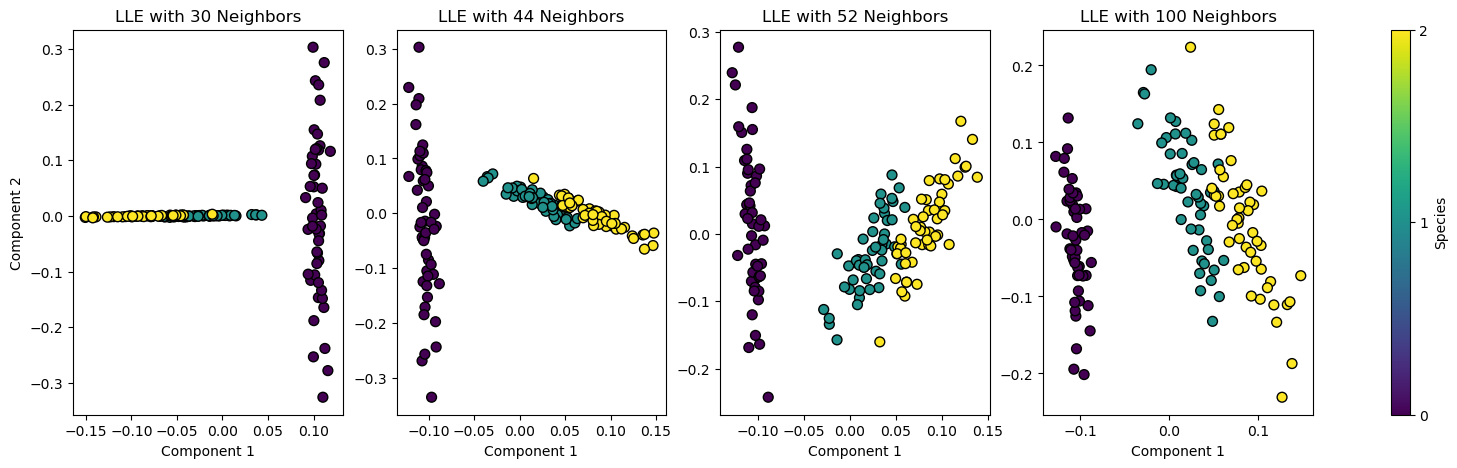

In [173]:
iris = load_iris()
X = iris.data
species = iris.target

# Define different neighbor settings to test
neighbor_settings = [30, 44, 52, 100]

# Plotting
fig, axes = plt.subplots(1, len(neighbor_settings), figsize=(20, 5))

for i, n_neighbors in enumerate(neighbor_settings):
    # Calculate geodesic neighbors using the adjusted function
    geodesic_neighbors = get_geodesic_neighbors(X, n_neighbors)
    
    # Use the my_lle function to embed the data into 2 dimensions
    embedding = my_isolle(X, n_neighbors, n_components=2)
    
    # Plot the embedded data, color by species
    ax = axes[i]
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=species, cmap='viridis', edgecolor='k', s=50)
    ax.set_title(f'LLE with {n_neighbors} Neighbors')
    ax.set_xlabel('Component 1')
    if i == 0:
        ax.set_ylabel('Component 2')

# Add a color bar
fig.colorbar(scatter, ax=axes.ravel().tolist(), ticks=np.arange(3), label='Species')
plt.show()

The embedding for small neighbor sizes (30) fails to preserve the overall structure, indicating that ISOLLE may require careful tuning to achieve meaningful results.
Larger neighbor sizes (100) oversmooth the local details, potentially reducing the interpretability of the embedding for finer patterns. Using 52 neighbors appears to provide the best trade-off for the Iris dataset. 

## Image Processing

Locally Linear Embedding can also be applied to image data, enabling us to explore and understand the relationships in high-dimensional image collections. We will apply LLE to the MNIST dataset, specifically focusing on the digit '1'. This will help us see how LLE handles variations in images of the same digit, potentially clustering similar shapes and styles together, which is useful for tasks like digit recognition and data visualization.

In [247]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)  # Ensure y is of integer type

unique, counts = np.unique(y, return_counts=True)

# Filter data for digit '1'
X = X[y == 1]
y = y[y == 1]

# Limit to first 1000 samples of digit '1' if there are enough samples
if len(X) > 1000:
    X = X[:2000]
    y = y[:2000]

# Reshape images for plotting
images = X.reshape(-1, 28, 28)


c:\Users\tanja\anaconda3\envs\sci-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


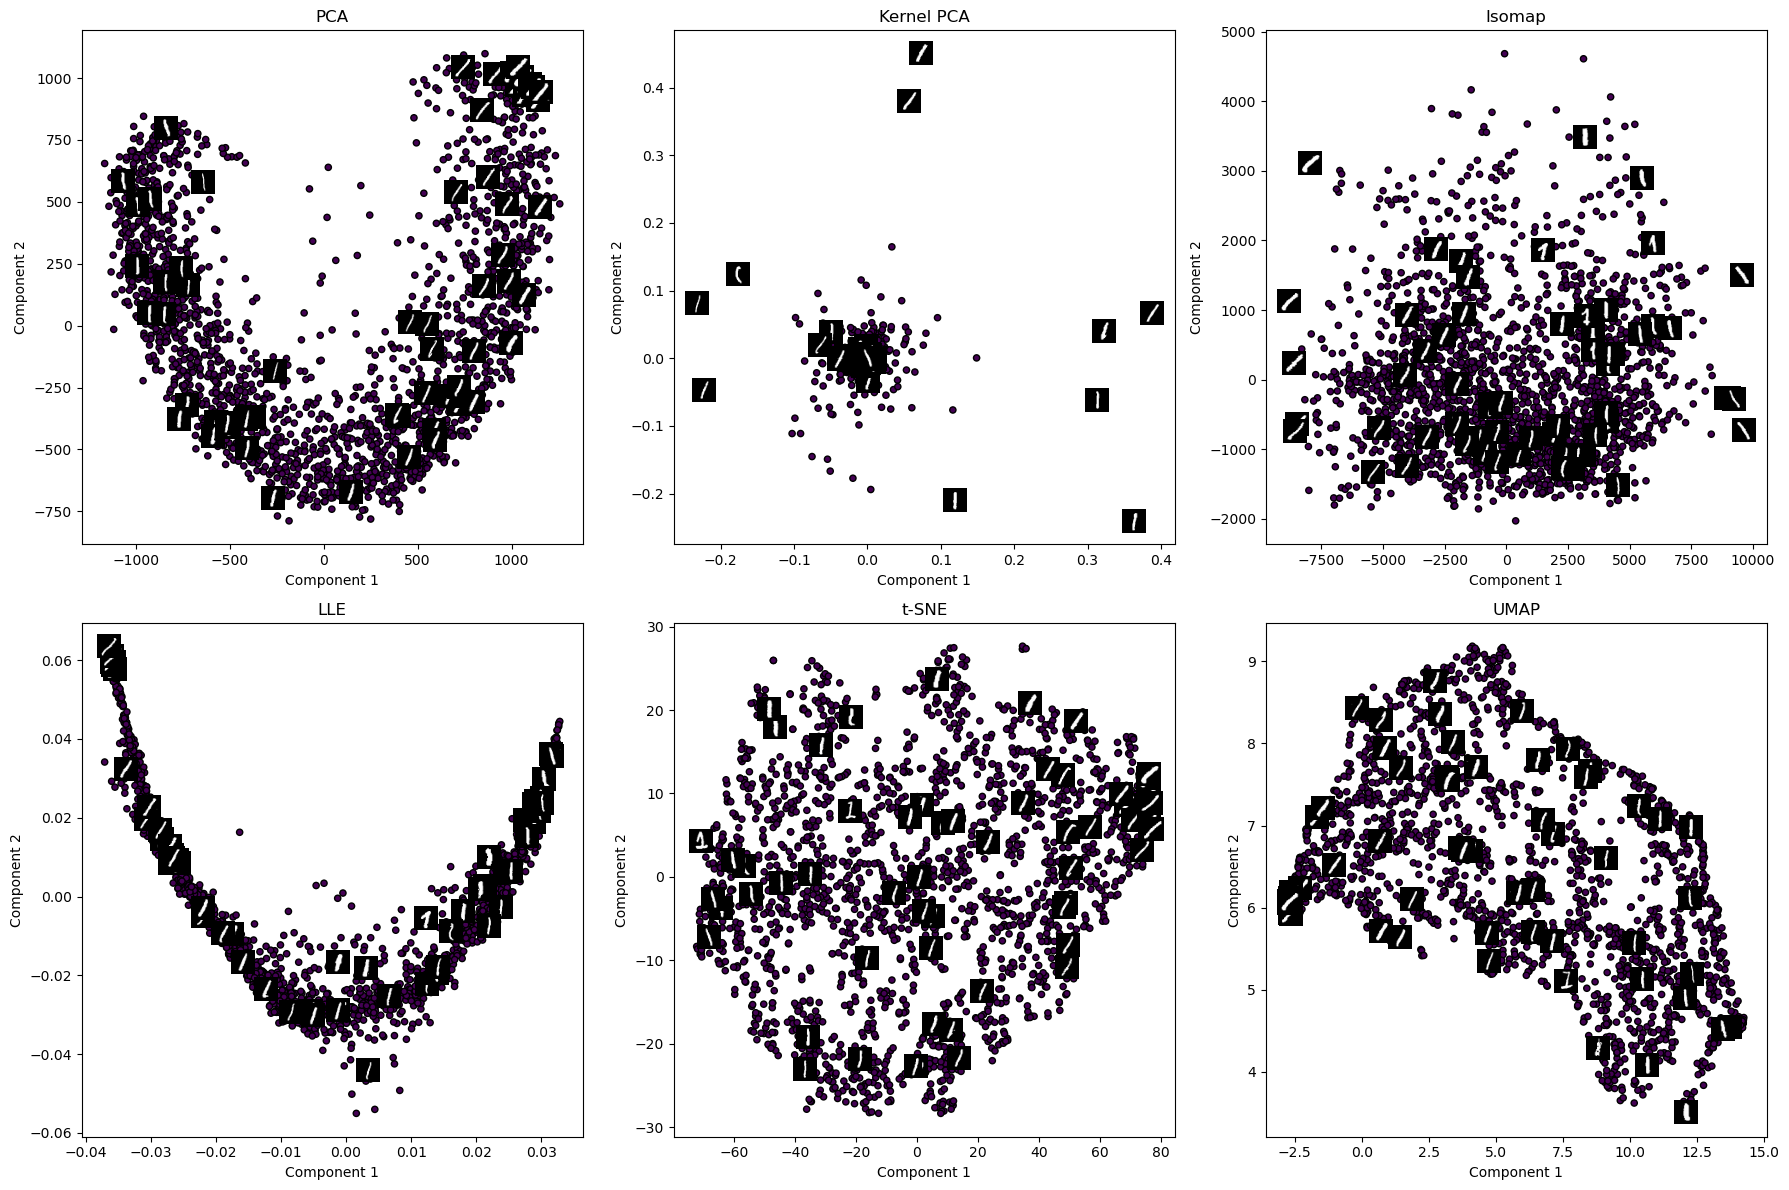

In [276]:

# Function to annotate representative points and outliers
def annotate_representative_points(X_transformed, images, ax, n_representatives=5, n_outliers=5):
    # Compute distances of all points to the mean of the data
    mean_point = X_transformed.mean(axis=0)
    distances_to_mean = np.linalg.norm(X_transformed - mean_point, axis=1)
    
    # Select representative points (randomly)
    representative_indices = np.random.choice(len(X_transformed), n_representatives, replace=False)
    for index in representative_indices:
        image = images[index]
        imagebox = OffsetImage(image, zoom=0.6, cmap='gray')
        ab = AnnotationBbox(imagebox, (X_transformed[index, 0], X_transformed[index, 1]), frameon=False)
        ax.add_artist(ab)


    # Select outliers (farthest from the mean)
    farthest_indices = np.argsort(distances_to_mean)[-n_outliers:]
    for index in farthest_indices:
        image = images[index]
        imagebox = OffsetImage(image, zoom=0.6, cmap='gray')
        ab = AnnotationBbox(imagebox, (X_transformed[index, 0], X_transformed[index, 1]), frameon=False)
        ax.add_artist(ab)



# Define dimensionality reduction techniques
techniques = {
    'PCA': PCA(n_components=2),
    'Kernel PCA': KernelPCA(n_components=2, kernel='rbf'),
    'Isomap': Isomap(n_components=2),
    'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=10),
    't-SNE': TSNE(n_components=2, perplexity=30, random_state=42),
    'UMAP': UMAP(n_neighbors=15, n_components=2, random_state=42)
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust layout for six plots
axes = axes.ravel()

# Loop through techniques
for i, (name, model) in enumerate(techniques.items()):
    # Fit and transform the data
    X_transformed = model.fit_transform(X)
    axes[i].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis', edgecolor='k', s=20)

    # Annotate representative points and outliers
    annotate_representative_points(X_transformed, images, axes[i], n_representatives=50, n_outliers=10)

    # Set plot titles and labels
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Component 1')
    axes[i].set_ylabel('Component 2')

plt.tight_layout()
plt.show()


Overall, LLE seems to offer the most distinctive and structured visualization, suggesting it might be the most effective technique for this particular application, capturing both local and global structures more visibly.

## Semantic Word Embedding

To demonstrate another application of Locally Linear Embedding, we can explore its use in the field of **semantic word embeddings**. By using LLE, we can reduce the dimensionality of word vectors extracted from large text corpora, like those from Google News, to visualize relationships and similarities between words in a lower-dimensional space.

##### Procedure: 
1. Word Vectors Loading: First, word vectors from a pre-trained in this example we use Google News Word2Vec are loaded. These vectors represent words in a high-dimensional space (300 dimensions), where the semantic and syntactic similarities between words are captured.

2. Selection of Words: From these vectors, we select a subset *word list* we are interested in analyzing, such as 'king', 'queen', 'apple', etc.

3. Dimensionality Reduction with LLE: LLE then takes these high-dimensional vectors and reduces them to 2 dimensions for visualization purposes. The key here is that LLE tries to maintain the local relationships between points.

4. Visualization: The reduced embeddings are plotted on a graph, allowing you to visually inspect how words relate to each other in this lower-dimensional space. For example, words with similar meanings or that belong to the same category (like animals or fruits) are clustered together.

In [218]:
def load_word_vectors():
    path = 'archive/GoogleNews-vectors-negative300.bin'
    word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)
    return word_vectors

load_word_vectors()


# Prepare selected words and their embeddings
def get_word_subset(word_vectors, word_list):
    selected_embeddings = []
    selected_words = []
    for word in word_list:
        if word in word_vectors:
            selected_words.append(word)
            selected_embeddings.append(word_vectors[word])
    return np.array(selected_embeddings), selected_words

# Apply LLE to the embeddings
def apply_lle(embeddings, n_neighbors=5, n_components=2):
    lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
    reduced_embeddings = lle.fit_transform(embeddings)
    return reduced_embeddings

# Visualize the results
def visualize_embeddings(reduced_embeddings, words):
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], marker='o', color='blue')
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=12)
    plt.title('LLE Semantic Word Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

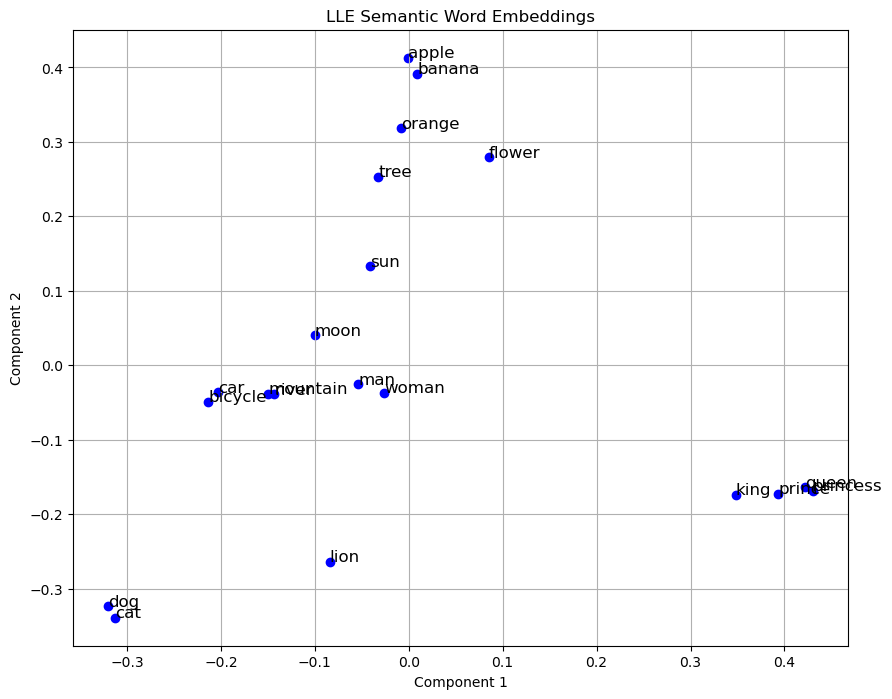

In [220]:
# Load word vectors and define a more comprehensive word list
word_vectors = load_word_vectors()
word_list = ['king', 'queen', 'man', 'woman', 'apple', 'orange', 'dog', 'cat', 'car', 'bicycle', 'banana', 'lion', 'prince', 'princess', 'tree', 'flower', 'river', 'mountain', 'sun', 'moon']

# Process and visualize embeddings
embeddings, selected_words = get_word_subset(word_vectors, word_list)
reduced_embeddings = apply_lle(embeddings)
visualize_embeddings(reduced_embeddings, selected_words)

The visualization shows the results of applying LLE to reduce the dimensionality of high-dimensional semantic word embeddings into two components. In this plot, we see distinct clusters of semantically similar words. For instance, 'king', 'queen' and 'prince' are closely positioned, 'cat' and 'dog', 'apple' and 'banana' also 'man' and 'woman', representing human genders. This spatial representation illustrates how LLE maintains the semantic relationships in a lower-dimensional space, revealing the underlying structure in the data.

## Final results 

#### Advantages of LLE

- **Preservation of Local Structures**: LLE excels at maintaining local relationships within the data, preserving the geometrical properties of nonlinear manifolds effectively.

- **Handling Non-Linearity**: Unlike linear methods such as PCA, LLE can manage nonlinear structures, making it suitable for complex datasets that contain curved or twisted distributions.

- **Dimensionality Reduction**: LLE simplifies high-dimensional data by reducing its dimensions while retaining the core characteristics, facilitating easier data analysis and visualization.

#### Disadvantages of LLE
- **Curse of Dimensionality**: LLE may suffer in extremely high-dimensional spaces as it requires a larger neighborhood size, increasing computational costs.

- **Memory and Computational Demands**: The method involves constructing a large adjacency matrix and performing eigenvalue decomposition, which can be resource-intensive, especially with large datasets.

- **Sensitivity to Noise and Outliers**: LLE's performance can be significantly degraded by noise and outliers, as these can disrupt the local linearity assumptions, leading to less accurate embeddings.


Locally Linear Embedding has proven its utility across various domains, including image processing, semantic analysis, and more. This method is particularly effective for tasks where understanding intrinsic structures within high-dimensional data is crucial. 

In practice, LLE shines in controlled datasets with moderate size and low noise levels, where uncovering local manifold structures is the priority. Its utility can be extended through hybrids like `Hessian LLE` or `modified LLE`, which address some of its limitations.